In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
from scipy import stats
from scipy.optimize import minimize

from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType

import optuna
from optuna.samplers import TPESampler

import tensorflow as tf  # another kernel: work in progress - MLP with BatchNorm, Convolutional

from utils import *
import gc
gc.enable()

In [3]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**models based on profile data**

In [102]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if df[col].nunique() > 20:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))
df, _ = get_encoded(df)

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X = X.drop(ID_COL, axis=1)

X.shape
# pay attention at EXTERNAL_WEIGHTED_SCORE: lots of NA values due to NA in additive terms (next hypothesis to fillna(0) in sum)

Memory usage of dataframe is 182.15 MB
Memory usage after optimization is: 90.60 MB
Decreased by 50.3%


(110093, 117)

In [38]:
# features, selected by BorutaShap and handy elimination
boruta = ['NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
          'DAYS_ON_LAST_JOB', 'ANNUITY_JOB', 'RATIO_CREDIT_TO_AGE', 'RATIO_CAR_TO_EXPERIENCE', 'RATIO_CAR_TO_AGE', 
          'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SALARY_JOB', 
          'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_3', 
          'NAME_CONTRACT_TYPE', 'CREDIT_JOB', 'AMOUNT_CREDIT', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
          'EXTERNAL_SCORE_WEIGHTED', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXTERNAL_SCORING_RATING_2', 
          'EDUCATION_FAMILY_STATUS', 'GENDER', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
          'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'AMOUNT_ANNUITY', 'OWN_CAR_AGE', 'RATIO_AGE_TO_EXPERIENCE', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXTERNAL_SCORING_RATING_1', 
          'TOTAL_SALARY_COUNT_BY_EDUCATION', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 
          'RATIO_SALARY_TO_AGE', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'SALARY_REGION_POPULATION', 'AGE_BIN', 'TOTAL_SALARY_MAX_BY_EDUCATION', 'NEW_STATUS_FMarried', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT']

**LGBM Base model (boruta features from profile.csv)**

Predictions for test are obtained by averaging CV estimators

In [39]:
# got 0.73211 on LB
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(lgbm_params_my, 
                                                            X[boruta], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=50)

Sat Aug 27 22:10:51 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.76910, Valid score = 0.74159
Fold 2, Train score = 0.78003, Valid score = 0.72489
Fold 3, Train score = 0.77269, Valid score = 0.73070
Fold 4, Train score = 0.77758, Valid score = 0.73267
Fold 5, Train score = 0.78181, Valid score = 0.71679
Train score by each fold: [0.7691, 0.78003, 0.77269, 0.77758, 0.78181]
Valid score by each fold: [0.74159, 0.72489, 0.7307, 0.73267, 0.71679]
Train mean score by each fold:0.77624 +/- 0.00471
Valid mean score by each fold:0.72933 +/- 0.00825
**************************************************
OOF-score: 0.72830


In [7]:
# this is no quite fair as we used oof values for early stopping in CV loop. CI would be optimistic
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm, roc_auc_score))

(0.7229144948491019, 0.7335425679214886)

In [40]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_lgbm])
# test_preds1 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds1 = test_preds.T.mean(axis=1)

**CatBoost Base model**

In [9]:
# 0.72989
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 6, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]

estimators_cat, oof_preds_cat = catboost_cross_validation(cat_params, 
                                                          X[boruta], 
                                                          y, 
                                                          cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                          rounds=50)

Sat Aug 27 21:53:56 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.75958, Valid score = 0.74136
Fold 2, Train score = 0.75875, Valid score = 0.72563
Fold 3, Train score = 0.75672, Valid score = 0.72853
Fold 4, Train score = 0.77492, Valid score = 0.73394
Fold 5, Train score = 0.76380, Valid score = 0.71967
Train score by each fold: [0.75958, 0.75875, 0.75672, 0.77492, 0.7638]
Valid score by each fold: [0.74136, 0.72563, 0.72853, 0.73394, 0.71967]
Train mean score by each fold:0.76275 +/- 0.00651
Valid mean score by each fold:0.72983 +/- 0.00738
**************************************************
OOF-score: 0.72913


In [10]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat, roc_auc_score))

(0.7241683790973656, 0.7342181540766775)

In [10]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_cat])
# test_preds2 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds2 = test_preds.T.mean(axis=1)

**Add Bureau features and new models**

In [11]:
bureau = bki_cr()
bureau.shape

(273131, 34)

In [41]:
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [ ]:
# select informative features with less overfitting params
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 212, 
                'learning_rate': 0.01, 
                'min_child_weight': 350, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

In [43]:
boruta_bureau = ['EXTERNAL_SCORE_WEIGHTED', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'DAYS_ON_LAST_JOB', 
                 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'ANNUITY_JOB', 
                 'EXTERNAL_SCORING_RATING_2', 'AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_3', 'AGE', 'AMOUNT_ANNUITY', 
                 'AMT_REQ_CREDIT_BUREAU_YEAR', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'RATIO_SALARY_TO_AGE', 
                 'EXTERNAL_SCORING_RATING_1', 'EXT_SCORE_3_ANNUITY', 'EXT_SCORE_3_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
                 'EXT_SCORE_2_ANNUITY', 'GENDER', 'EDUCATION_LEVEL_Higher education', 'EXT_SCORE_2_AMT_CREDIT', 
                 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
                 'OWN_CAR_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'EDUCATION_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 
                 'NEW_STATUS_FMarried', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'CREDIT_JOB',
                 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 
                 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_EXPERIENCE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
                 'RATIO_ANNUITY_TO_AGE', 'NAME_CONTRACT_TYPE', 'RATIO_AGE_TO_EXPERIENCE', 
                 'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'SALARY_JOB', 
                 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 
                 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_MAX_BY_EDUCATION', 
                 'AMOUNT_ANNUITY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_MAX_AGE_INTERVAL', 'AGE_BIN', 'REGION_POPULATION', 
                 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'BURO_CREDIT_TYPE_Consumer credit_MEAN']

**LGBM model 2**

In [44]:
# 0.73209
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 42,
    'max_depth': 5,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

estimators_lgbm2, oof_preds_lgbm2 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[boruta_bureau], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//2, shuffle=True), 
                                                              rounds=50)

Sat Aug 27 22:12:53 2022, Cross-Validation, 110093 rows, 56 cols
Fold 1, Train score = 0.76513, Valid score = 0.72499
Fold 2, Train score = 0.76073, Valid score = 0.73407
Fold 3, Train score = 0.78405, Valid score = 0.72414
Fold 4, Train score = 0.77584, Valid score = 0.73040
Fold 5, Train score = 0.78912, Valid score = 0.73853
Train score by each fold: [0.76513, 0.76073, 0.78405, 0.77584, 0.78912]
Valid score by each fold: [0.72499, 0.73407, 0.72414, 0.7304, 0.73853]
Train mean score by each fold:0.77497 +/- 0.01080
Valid mean score by each fold:0.73043 +/- 0.00544
**************************************************
OOF-score: 0.73003


In [17]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm2, roc_auc_score))

(0.7246335209094215, 0.7355713388651984)

In [16]:
preds = pd.DataFrame(data=np.array([model.predict_proba(X[boruta_bureau])[:,1] for model in estimators_lgbm2]).T)
mean_scores(preds, y)
# weights optimization do not improve LB

AMean score: 0.77067
GMean score: 0.76982
Rank  score: 0.76950
GMean  rank: 0.76875


In [17]:
data_test.drop(TARGET, axis=1, inplace=True)
data_test = data_test.merge(bureau, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [18]:
test_preds = np.array([model.predict_proba(data_test[boruta_bureau])[:,1] for model in estimators_lgbm2])
# test_preds3 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds3 = test_preds.T.mean(axis=1)

In [29]:
test_preds3.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 216k/4.90M [00:00<00:02, 1.65MB/s]
 38%|###7      | 1.85M/4.90M [00:00<00:00, 3.67MB/s]
 93%|#########2| 4.55M/4.90M [00:00<00:00, 9.04MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.34MB/s]


**CatBoost model 2**

In [19]:
# 0.73096
cat_params2 = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 2000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 8, 
                'l2_leaf_reg': 30,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]

estimators_cat2, oof_preds_cat2 = catboost_cross_validation(cat_params2, 
                                                            X[boruta_bureau], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed//2, shuffle=True), 
                                                            rounds=50)

Sat Aug 27 21:57:17 2022, Cross-Validation, 110093 rows, 56 cols
Fold 1, Train score = 0.76455, Valid score = 0.72262
Fold 2, Train score = 0.78430, Valid score = 0.73747
Fold 3, Train score = 0.77374, Valid score = 0.72104
Fold 4, Train score = 0.77971, Valid score = 0.73249
Fold 5, Train score = 0.77683, Valid score = 0.73974
Train score by each fold: [0.76455, 0.7843, 0.77374, 0.77971, 0.77683]
Valid score by each fold: [0.72262, 0.73747, 0.72104, 0.73249, 0.73974]
Train mean score by each fold:0.77583 +/- 0.00662
Valid mean score by each fold:0.73067 +/- 0.00761
**************************************************
OOF-score: 0.73052


In [22]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat2, roc_auc_score))

(0.7252160055955358, 0.7357849516453057)

In [20]:
test_preds = np.array([model.predict_proba(data_test[boruta_bureau])[:,1] for model in estimators_cat2])
# test_preds4 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds4 = test_preds.T.mean(axis=1)

In [51]:
test_preds4.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  5%|4         | 240k/4.90M [00:00<00:03, 1.55MB/s]
 41%|####      | 2.00M/4.90M [00:00<00:00, 3.83MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.38MB/s]


**Models built on permutation data**

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:35<00:00,  4.24it/s]


In [22]:
deltas = deltas[deltas>0].index.tolist()

In [23]:
lgbm_params_my = {
                    'boosting_type': 'gbdt',
                    'n_estimators': 1000,
                    'learning_rate': 0.01,
                    'num_leaves': 44,
                    'max_depth': 8,
                    'subsample_for_bin': 240000,
                    'reg_alpha': 0.436193,
                    'reg_lambda': 0.479169,
                    'colsample_bytree': 0.508716,
                    'min_split_gain': 0.024766,
                    'subsample': 0.8,
                    'is_unbalance': False,
                    'random_state': seed,
}

estimators_lgbm4, oof_preds_lgbm4 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[deltas], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=50)

Sat Aug 27 22:02:00 2022, Cross-Validation, 110093 rows, 63 cols
Fold 1, Train score = 0.81922, Valid score = 0.74542
Fold 2, Train score = 0.81756, Valid score = 0.72643
Fold 3, Train score = 0.79086, Valid score = 0.73290
Fold 4, Train score = 0.82197, Valid score = 0.73211
Fold 5, Train score = 0.81063, Valid score = 0.71904
Train score by each fold: [0.81922, 0.81756, 0.79086, 0.82197, 0.81063]
Valid score by each fold: [0.74542, 0.72643, 0.7329, 0.73211, 0.71904]
Train mean score by each fold:0.81205 +/- 0.01124
Valid mean score by each fold:0.73118 +/- 0.00868
**************************************************
OOF-score: 0.73046


In [81]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm4, roc_auc_score))

(0.7253414680696273, 0.7355875521562709)

In [24]:
test_preds = np.array([model.predict_proba(data_test[deltas])[:,1] for model in estimators_lgbm4])
# test_preds7 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds7 = test_preds.T.mean(axis=1)

In [90]:
test_preds7.to_csv('submission.csv', index=False) # 0.73250
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 224k/4.90M [00:00<00:03, 1.59MB/s]
 45%|####4     | 2.18M/4.90M [00:00<00:00, 10.5MB/s]
 67%|######7   | 3.29M/4.90M [00:00<00:00, 3.33MB/s]
 81%|########1 | 3.97M/4.90M [00:01<00:00, 3.52MB/s]
 93%|#########2| 4.54M/4.90M [00:01<00:00, 3.67MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 1.77MB/s]


**Model built on exhaustive feature selection**

In [25]:
exhaust = ['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB', 'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
           'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY', 'EXTERNAL_SCORING_RATING_2', 'AGE', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
           'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 
           'RATIO_CAR_TO_AGE', 'EXT_SCORES_min', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
           'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 
           'NEW_STATUS_MSeparated', 'EXT_SCORE_3_ANNUITY', 'NEW_STATUS_MMarried', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
           'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS', 
           'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_AGE_INTERVAL', 'AMOUNT_CREDIT_MEAN_BY_FAMILY_STATUS', 
           'NEW_STATUS_MCivil marriage', 'EXT_SCORE_1_AMT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'GENDER',
           'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORE_WEIGHTED', 'EXTERNAL_SCORING_RATING_1']

In [26]:
# got 0.73211 on LB
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.035,
    'num_leaves': 12,
    'max_depth': 12,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 56,
    'random_state': seed
}

estimators_lgbm3, oof_preds_lgbm3 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[exhaust], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Sat Aug 27 22:02:28 2022, Cross-Validation, 110093 rows, 40 cols
Fold 1, Train score = 0.76411, Valid score = 0.73506
Fold 2, Train score = 0.75483, Valid score = 0.72234
Fold 3, Train score = 0.76071, Valid score = 0.73413
Fold 4, Train score = 0.76178, Valid score = 0.73187
Fold 5, Train score = 0.76075, Valid score = 0.73313
Train score by each fold: [0.76411, 0.75483, 0.76071, 0.76178, 0.76075]
Valid score by each fold: [0.73506, 0.72234, 0.73413, 0.73187, 0.73313]
Train mean score by each fold:0.76044 +/- 0.00306
Valid mean score by each fold:0.73131 +/- 0.00461
**************************************************
OOF-score: 0.73059


In [26]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm3, roc_auc_score))

(0.7253662532140501, 0.7360132526893445)

In [27]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_lgbm3])
# test_preds5 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds5 = test_preds.T.mean(axis=1)

In [198]:
test_preds5.to_csv('submission.csv', index=False) # 0.73197
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 208k/4.90M [00:00<00:03, 1.49MB/s]
 41%|####1     | 2.02M/4.90M [00:00<00:01, 2.74MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.29MB/s]


**CatBoost**

In [28]:
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'Lossguide', 
                'objective': 'Logloss',  
                'boosting_type': 'Plain', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.9,  
                'depth': 4, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,
                'num_leaves': 32
}

estimators_cat3, oof_preds_cat3 = catboost_cross_validation(cat_params, 
                                                            X[exhaust], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed%5, shuffle=True), 
                                                            rounds=50)

Sat Aug 27 22:02:37 2022, Cross-Validation, 110093 rows, 40 cols
Fold 1, Train score = 0.76473, Valid score = 0.73199
Fold 2, Train score = 0.77973, Valid score = 0.72455
Fold 3, Train score = 0.74876, Valid score = 0.73054
Fold 4, Train score = 0.76708, Valid score = 0.73217
Fold 5, Train score = 0.77533, Valid score = 0.73549
Train score by each fold: [0.76473, 0.77973, 0.74876, 0.76708, 0.77533]
Valid score by each fold: [0.73199, 0.72455, 0.73054, 0.73217, 0.73549]
Train mean score by each fold:0.76713 +/- 0.01067
Valid mean score by each fold:0.73095 +/- 0.00359
**************************************************
OOF-score: 0.73049


In [29]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat3, roc_auc_score))

(0.7250682605387699, 0.7357072568958616)

In [29]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_cat3])
# test_preds6 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds6 = test_preds.T.mean(axis=1)

In [227]:
test_preds6.to_csv('submission.csv', index=False) # 0.73229
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.87M [00:00<?, ?B/s]
  4%|4         | 208k/4.87M [00:00<00:03, 1.45MB/s]
 38%|###8      | 1.88M/4.87M [00:00<00:00, 3.61MB/s]
 96%|#########5| 4.66M/4.87M [00:00<00:00, 8.91MB/s]
100%|##########| 4.87M/4.87M [00:02<00:00, 2.38MB/s]


### Add history data

In [57]:
history_train, target, history_test = prepare_history()

Final shapes: (110093, 172) (165141, 172)


In [58]:
hist_importance = calculate_feature_separating_ability(history_train, target)

In [61]:
history_features = hist_importance[hist_importance > 0.005].index.tolist()

In [63]:
history_train = history_train[history_features + [ID_COL]]
history_test = history_test[history_features + [ID_COL]]

In [ ]:
# restart prepare profile

In [103]:
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [104]:
data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [ ]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

In [107]:
total_boruta = ['EXTERNAL_SCORING_RATING_2', 'EXT_SCORE_1_AMT_CREDIT', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
                'AMOUNT_CREDIT_MAX_AGE_INTERVAL', 'CREDIT_JOB', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'EXT_SCORES_max',
                'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 
                'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_1_ANNUITY', 'OWN_CAR_AGE', 'EXT_SCORES_nanmedian', 
                'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_var', 'EXTERNAL_SCORING_RATING_3', 
                'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXT_SCORES_min', 'RATIO_SALARY_TO_AGE', 'RATIO_CAR_TO_AGE', 
                'EXT_SCORE_2_AMT_CREDIT', 'AMOUNT_ANNUITY', 'NAME_CONTRACT_TYPE', 'EDUCATION_LEVEL_Higher education', 
                'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'EXTERNAL_SCORE_WEIGHTED', 'AMOUNT_CREDIT', 'DAYS_ON_LAST_JOB', 
                'NEW_STATUS_FMarried', 'RATIO_CAR_TO_EXPERIENCE', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
                'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_1', 'GENDER', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 
                'EXT_SCORE_3_ANNUITY', 'ANNUITY_JOB', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 
                'RATIO_AGE_TO_EXPERIENCE', 'SALARY_JOB', 'AGE', 'EXT_SCORES_mean', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE_BIN', 
                'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 
                'SALARY_REGION_POPULATION', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 
                'TOTAL_SALARY_MAX_AGE_INTERVAL', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS',
                'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
                'EXT_SCORE_2_ANNUITY', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 
                'AMT_REQ_CREDIT_BUREAU_WEEK', 'REGION_POPULATION']

total_boruta2 = total_boruta + history_features

In [120]:
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.045,
    'num_leaves': 12,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 20,
    'random_state': seed
}

estimators_lgbm5, oof_preds_lgbm5 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[total_boruta], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Sat Aug 27 22:52:32 2022, Cross-Validation, 110093 rows, 63 cols
Fold 1, Train score = 0.76534, Valid score = 0.73181
Fold 2, Train score = 0.77584, Valid score = 0.72142
Fold 3, Train score = 0.77393, Valid score = 0.73361
Fold 4, Train score = 0.77253, Valid score = 0.73284
Fold 5, Train score = 0.76557, Valid score = 0.73244
Train score by each fold: [0.76534, 0.77584, 0.77393, 0.77253, 0.76557]
Valid score by each fold: [0.73181, 0.72142, 0.73361, 0.73284, 0.73244]
Train mean score by each fold:0.77064 +/- 0.00436
Valid mean score by each fold:0.73042 +/- 0.00454
**************************************************
OOF-score: 0.72972


**Combining oof predictions**

In [54]:
oof_predictions = pd.DataFrame(data={'m1': oof_preds_lgbm, 'm2': oof_preds_cat, 'm3': oof_preds_lgbm2, 'm4': oof_preds_cat2,
                                     'm5': oof_preds_lgbm3, 'm6': oof_preds_cat3, 'm7': oof_preds_lgbm4})

In [55]:
test_probs = pd.DataFrame(data={'m1': test_preds1, 'm2': test_preds2, 'm3': test_preds3, 'm4': test_preds4,
                                'm5': test_preds5, 'm6': test_preds6, 'm7': test_preds7})

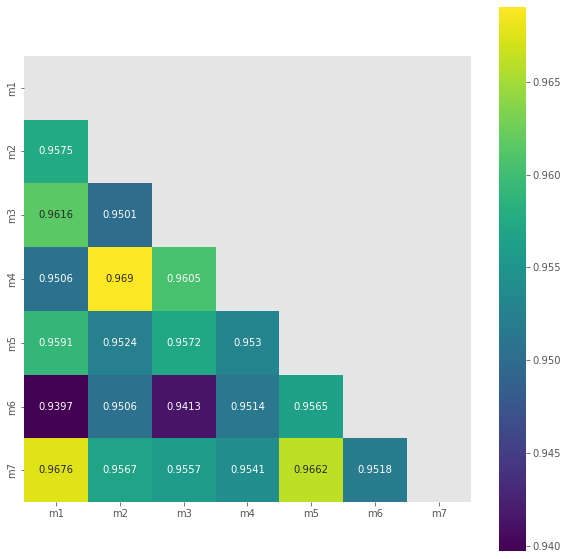

In [45]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

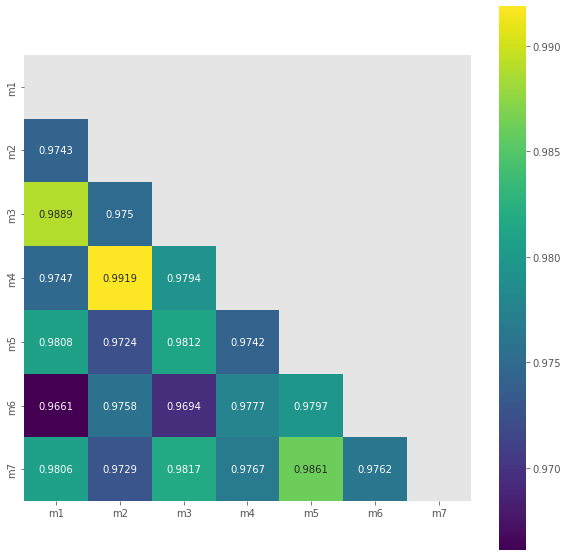

In [46]:
corr = test_probs.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [49]:
mean_scores(oof_predictions, y)

AMean score: 0.73285
GMean score: 0.73302
Rank  score: 0.73304
GMean  rank: 0.73302


In [153]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',  # lsqr: same LB score
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=y,
                                                             cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73121, Valid score = 0.74916
Fold 2, Train score: 0.73181, Valid score = 0.74376
Fold 3, Train score: 0.73329, Valid score = 0.72918
Fold 4, Train score: 0.73354, Valid score = 0.72829
Fold 5, Train score: 0.73214, Valid score = 0.73926
Fold 6, Train score: 0.73326, Valid score = 0.73053
Fold 7, Train score: 0.73198, Valid score = 0.73982
Fold 8, Train score: 0.73324, Valid score = 0.72932
Fold 9, Train score: 0.73370, Valid score = 0.72554
Fold 10, Train score: 0.73473, Valid score = 0.71518
Train score by each fold: [0.73121, 0.73181, 0.73329, 0.73354, 0.73214, 0.73326, 0.73198, 0.73324, 0.7337, 0.73473]
Valid score by each fold: [0.74916, 0.74376, 0.72918, 0.72829, 0.73926, 0.73053, 0.73982, 0.72932, 0.72554, 0.71518]
Train mean score by each fold:0.73289 +/- 0.00101
Valid mean score by each fold:0.73300 +/- 0.00945
**************************************************


In [154]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)
#test_fin = np.average(test_fin, axis=1)
test_fin = stats.gmean(test_fin, axis=1)

In [155]:
# LDA predictions: 0.73312 on first 2 cat and lgbm models # 0.73337 - 5 models; 0.73358 - 6 models, 0.73342 on 7 models
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

In [53]:
# 0.73371: 6 models with simple gmean averaging on obtained test scores; 0.73370 on 7 models
test_fin = stats.gmean(test_probs, axis=1)
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.89M [00:00<?, ?B/s]
  4%|4         | 224k/4.89M [00:00<00:03, 1.33MB/s]
 39%|###8      | 1.89M/4.89M [00:00<00:00, 3.67MB/s]
100%|##########| 4.89M/4.89M [00:02<00:00, 2.25MB/s]


In [101]:
oof_total_scores = stats.gmean(oof_predictions, axis=1)
stability = create_bootstrap_metrics(y, oof_total_scores, roc_auc_score)

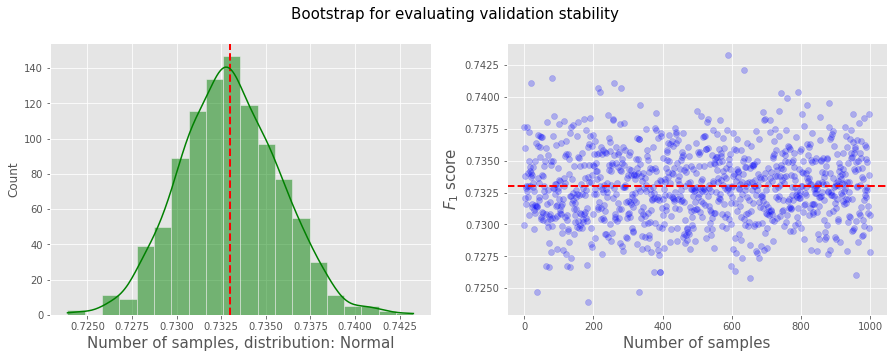

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(stability)), stability, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("$F_1$ score", size=15)
distribution = "Normal" if stats.shapiro(stability)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(stability), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(stability), lw=2, ls='--', c='red')
sns.histplot(stability, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()

In [105]:
# optimization with gmean: 0.73348

results_list = []   
weights_list = []  
preds = oof_predictions.values

def weights_objective(weights):
    # y_ens = np.average(preds, axis=1, weights=weights)
    y_ens = stats.gmean(preds, axis=1, weights=weights)
    return roc_auc_score(y, y_ens)

for k in range(100):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))


Optimized weights:
Best score: 0.7331


In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

logreg = LogisticRegression(class_weight=None, 
                            solver='liblinear', 
                            penalty='l2', 
                            C=0.1, 
                            random_state=seed,
                            n_jobs=-1)

pipe = make_pipeline(PCA(n_components=6, random_state=seed), logreg)

estimators_log, oof_preds_log, mean_score_log = cross_validation(model=pipe,
                                                                 X=oof_predictions,
                                                                 y=y,
                                                                 cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73131, Valid score = 0.74930
Fold 2, Train score: 0.73192, Valid score = 0.74367
Fold 3, Train score: 0.73329, Valid score = 0.73053
Fold 4, Train score: 0.73365, Valid score = 0.72793
Fold 5, Train score: 0.73232, Valid score = 0.73917
Fold 6, Train score: 0.73341, Valid score = 0.73019
Fold 7, Train score: 0.73214, Valid score = 0.74082
Fold 8, Train score: 0.73332, Valid score = 0.73023
Fold 9, Train score: 0.73385, Valid score = 0.72529
Fold 10, Train score: 0.73490, Valid score = 0.71706
Train score by each fold: [0.73131, 0.73192, 0.73329, 0.73365, 0.73232, 0.73341, 0.73214, 0.73332, 0.73385, 0.7349]
Valid score by each fold: [0.7493, 0.74367, 0.73053, 0.72793, 0.73917, 0.73019, 0.74082, 0.73023, 0.72529, 0.71706]
Train mean score by each fold:0.73301 +/- 0.00102
Valid mean score by each fold:0.73342 +/- 0.00915
**************************************************


In [148]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_log]).T
test_fin = pd.DataFrame(data=test_fin)
test_fin = np.average(test_fin, axis=1)

In [149]:
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})  # 0.73345 on LB
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.89M [00:00<?, ?B/s]
  5%|4         | 240k/4.89M [00:00<00:02, 1.96MB/s]
 40%|###9      | 1.94M/4.89M [00:00<00:00, 3.77MB/s]
100%|##########| 4.89M/4.89M [00:02<00:00, 2.40MB/s]


**Merge part 1 and part 2**

In [165]:
nonzero = pd.read_csv('nonzero.csv')
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})

In [166]:
fin_sub = fin_sub.merge(nonzero, on=ID_COL, how='left')

In [169]:
# fin_sub[TARGET] = np.where(fin_sub['TARGET_y'].isna(), fin_sub['TARGET_x'], fin_sub['TARGET_y'])  # 0.73290

fin_sub[TARGET] = (fin_sub['TARGET_x'] * fin_sub['TARGET_y'])**(1/2)  # 0.73337
fin_sub.loc[fin_sub[TARGET].isna(), TARGET] = fin_sub.loc[fin_sub[TARGET].isna(), 'TARGET_x']

In [170]:
fin_sub.drop(['TARGET_y', 'TARGET_x'], axis=1, inplace=True)

In [171]:
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.91M [00:00<?, ?B/s]
  5%|4         | 248k/4.91M [00:00<00:02, 1.79MB/s]
 15%|#5        | 768k/4.91M [00:00<00:02, 1.63MB/s]
 46%|####6     | 2.27M/4.91M [00:00<00:00, 4.97MB/s]
 86%|########6 | 4.23M/4.91M [00:00<00:00, 8.40MB/s]
100%|##########| 4.91M/4.91M [00:02<00:00, 2.47MB/s]


### Feature selection

In [108]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [109]:
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed).fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=inspector,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5004


In [111]:
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:33<00:00,  3.51it/s]


In [116]:
perm = deltas[deltas >= 0].index.tolist()

In [133]:
perm = perm + ["EXTERNAL_SCORE_WEIGHTED", "EXTERNAL_SCORING_RATING_1"]

In [142]:
# select best feature set by exhaustive method
lgbm_params_my = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 1000,
                'learning_rate': 0.03,
                'num_leaves': 42,
                'max_depth': 10,
                'reg_alpha': 0.05,
                'reg_lambda': 0.06,
                'subsample': 0.8,
                'min_child_weight': 60,
                'random_state': seed
}

best_selector = BestSet(lgbm_params_my, k_features=40).fit(X[perm], y)

In [ ]:
max(best_selector.scores_), X[perm][list(best_selector.subsets_[np.argmax(best_selector.scores_)])]

In [153]:
X[perm].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])], max(best_selector.scores_)

(Index(['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB',
        'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY',
        'EXTERNAL_SCORING_RATING_2', 'AGE', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
        'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL',
        'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 'RATIO_CAR_TO_AGE',
        'EXT_SCORES_min', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY',
        'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
        'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE',
        'TOTAL_SALARY_MAX_AGE_INTERVAL', 'NEW_STATUS_MSeparated',
        'EXT_SCORE_3_ANNUITY', 'NEW_STATUS_MMarried',
        'TOTAL_SALARY_MEAN_BY_EDUCATION',
        'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS',
        'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SAL

#### Watch profile features combinations (fillna before add, multiply, etc.) - new ipynb - did not work
#### target encoding did not work
#### adding history features did not work

### PART I 

Train CV ensemble models on existing profile data only with hold-out set, CI.

Combine part I and part II: replace samples scores, amean, gmean

### Optuna search